In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from pmdarima.arima import auto_arima
import tensorflow as tfa
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')
data.info()

data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"gas_price",
        "Date":"date"
    }
)

data = data.fillna(method = 'pad')

data['date'] = pd.to_datetime(data['date'], format = "%d/%m/%Y")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        6505 non-null   datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  6504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.8 KB


In [4]:
weather = pd.read_csv('lafayettetempdata.csv')

weather = weather.rename(
    columns={
        "TMIN (Degrees Fahrenheit)":"TMIN",
        "Date":"date"
    }
)

weather['date'] = pd.to_datetime(weather['date'],errors='coerce')
weather["date"] = weather["date"].dt.strftime("%Y-%m-%d")
weather['date'] = pd.to_datetime(weather['date'], format = "%Y-%m-%d")
# weather['date'] = pd.to_datetime(weather['date'], format = "%d/%m/%Y")
weather

,date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN,PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1893-01-01,NaN,57.0,40.0,0.01,0.0,NaN
1,1893-01-02,NaN,71.0,37.0,NaN,0.0,NaN
2,1893-01-03,NaN,64.0,39.0,NaN,0.0,NaN
3,1893-01-04,NaN,70.0,38.0,NaN,0.0,NaN
4,1893-01-05,NaN,70.0,41.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...
47504,2023-02-24,NaN,82.0,72.0,0.00,0.0,NaN
47505,2023-02-25,NaN,83.0,68.0,0.00,0.0,NaN
47506,2023-02-26,NaN,79.0,68.0,0.00,0.0,NaN
47507,2023-02-27,NaN,82.0,68.0,0.00,0.0,NaN


In [6]:
merged_df = pd.merge(data, weather[['date', 'TMIN']], on='date', how='left')
merged_df

,date,gas_price,TMIN
0,1997-01-07,3.82,40.0
1,1997-01-08,3.80,39.0
2,1997-01-09,3.61,32.0
3,1997-01-10,3.92,31.0
4,1997-01-13,4.00,30.0
...,...,...,...
6500,2022-11-09,3.46,61.0
6501,2022-11-10,4.80,52.0
6502,2022-11-11,4.80,51.0
6503,2022-11-14,6.24,39.0


In [7]:
merged_df.set_index('date', inplace=True)

# Use linear interpolation to impute missing values
merged_df['TMIN'] = merged_df['TMIN'].interpolate(method='linear')

# Reset the index to default and save the dataframe
merged_df = merged_df.reset_index()

In [8]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [9]:
weather = weather.set_index('date')
new_temp = weather['2022-11-16':]


In [10]:
new_temp

,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN,PRCP (Inches),SNOW (Inches),SNWD (Inches)
date,,,,,,
2022-11-16,NaN,52.0,42.0,0.00,0.0,NaN
2022-11-17,NaN,57.0,36.0,0.00,0.0,NaN
2022-11-18,NaN,61.0,32.0,0.00,0.0,NaN
2022-11-19,NaN,51.0,44.0,0.68,NaN,NaN
2022-11-20,NaN,59.0,40.0,0.00,0.0,NaN
...,...,...,...,...,...,...
2023-02-24,NaN,82.0,72.0,0.00,0.0,NaN
2023-02-25,NaN,83.0,68.0,0.00,0.0,NaN
2023-02-26,NaN,79.0,68.0,0.00,0.0,NaN


In [12]:

try:
	series = merged_df['gas_price']
	# seasonal difference
	X = series.values
	days = 365
	differenced = difference(X, days)
	# fit model
	# model = sm.tsa.arima.ARIMA(series, order=(3, 0, 2))
	model = ARIMA(merged_df['gas_price'], exog=merged_df[['TMIN']], order=(3, 1, 2))
	model_fit = model.fit()
	# multi-step out-of-sample forecast
	start_index = len(differenced)
	end_index = start_index + 100
	forecast = model_fit.predict(start=start_index, end=end_index,exog=merged_df[['TMIN']])
	# invert the differenced forecast to something usable
	# print(forecast)
	history = [x for x in X]
	day = 1
	inverted_list = []
	for yhat in forecast:
		inverted = inverse_difference(history, yhat, days)
		inverted_list.append(inverted)
		print('Day %d: %f' % (day, inverted))
		history.append(inverted)
		day += 1
except Exception as e:
	print("Error:", e)

c:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Day 1: 6.004788
Day 2: 5.971744
Day 3: 6.072733
Day 4: 6.231695
Day 5: 6.227917
Day 6: 6.350248
Day 7: 6.568382
Day 8: 6.612761
Day 9: 6.522054
Day 10: 6.499238
Day 11: 6.462506
Day 12: 6.366339
Day 13: 6.368245
Day 14: 6.570222
Day 15: 6.636099
Day 16: 6.667962
Day 17: 7.023574
Day 18: 7.299344
Day 19: 7.465360
Day 20: 7.482297
Day 21: 7.381407
Day 22: 7.328960
Day 23: 7.329275
Day 24: 7.209423
Day 25: 7.275587
Day 26: 7.417786
Day 27: 7.447151
Day 28: 7.573871
Day 29: 7.439732
Day 30: 7.381955
Day 31: 7.460729
Day 32: 7.559093
Day 33: 7.740577
Day 34: 7.915212
Day 35: 8.080789
Day 36: 8.141187
Day 37: 8.208832
Day 38: 8.220888
Day 39: 8.100720
Day 40: 7.965690
Day 41: 7.972458
Day 42: 8.086115
Day 43: 8.247950
Day 44: 8.461983
Day 45: 8.423165
Day 46: 8.414789
Day 47: 8.345319
Day 48: 8.189910
Day 49: 8.197837
Day 50: 8.054842
Day 51: 7.892243
Day 52: 7.888074
Day 53: 7.792676
Day 54: 7.712205
Day 55: 7.798419
Day 56: 7.881798
Day 57: 7.872066
Day 58: 7.995405
Day 59: 8.081717
Day 60

In [13]:
dates = pd.date_range(start='2022-11-16', periods=100, freq='D')
dates = pd.DataFrame(dates)

df1 = pd.DataFrame(inverted_list)
dates['predicted_mean'] = df1
dates.columns.values[0] = 'date'

data1 = pd.read_csv('forecast.csv')
data1 = data1.drop('predicted_mean', axis=1)

dates['date'] = pd.to_datetime(dates['date'])
data1['date'] = pd.to_datetime(data1['date'])

df_merged = pd.merge(data1, dates[['date', 'predicted_mean']], on='date', how='inner')
df_merged

,date,gas_price,predicted_mean
0,2022-11-16,5.88,6.004788
1,2022-11-17,6.20,5.971744
2,2022-11-18,6.10,6.072733
3,2022-11-21,6.23,6.350248
4,2022-11-22,6.27,6.568382
...,...,...,...
61,2023-02-15,2.45,10.934138
62,2023-02-16,2.48,11.517465
63,2023-02-17,2.28,11.276592
64,2023-02-21,2.12,9.890551


In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_merged['gas_price'], df_merged['predicted_mean'])

29.657053184581848

In [16]:
dates

,date,predicted_mean
0,2022-11-16,6.004788
1,2022-11-17,5.971744
2,2022-11-18,6.072733
3,2022-11-19,6.231695
4,2022-11-20,6.227917
...,...,...
95,2023-02-19,9.965751
96,2023-02-20,9.782471
97,2023-02-21,9.890551
98,2023-02-22,10.084240


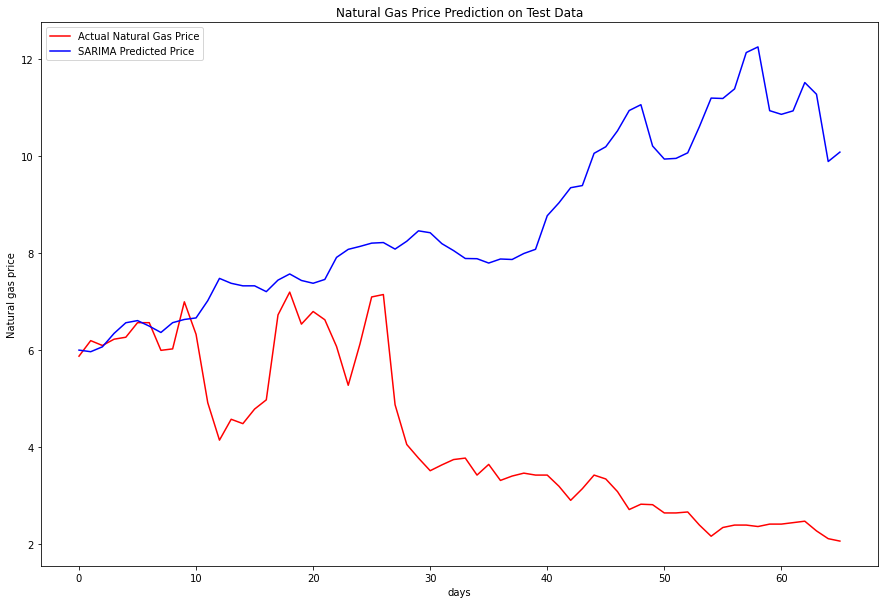

In [17]:
# import matplotlib.dates as mdates
plt.figure(figsize = (15, 10))
# plt.plot(train,color = 'black',label = "train")
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['predicted_mean'], color = 'blue', label = 'SARIMA Predicted Price')
plt.title("Natural Gas Price Prediction on Test Data")
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()